In [1]:
import numpy as np
import pandas as pd
#from skimage import io
import skimage.measure as measure
import os
from sklearn.decomposition import PCA

Image shape: (256, 256)


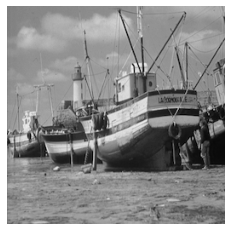

In [2]:
import skimage.io as io

# Load the PNG image
image_path = 'boat.png'  # Replace with the path to your PNG image
image_array = io.imread(image_path)

# Now, 'image_array' contains the image as a NumPy array
# You can access and manipulate the image using standard NumPy operations

# For example, you can print the shape of the image array
print("Image shape:", image_array.shape)

# You can also display the image using matplotlib
import matplotlib.pyplot as plt

plt.imshow(image_array, cmap='gray', vmin=0, vmax=255)
plt.axis('off')  # Turn off axis labels
plt.show()

In [3]:
image_array
image_array = image_array.astype(float)

# hyper-parameter
K = 3
L = 9
# K and L are odd numbers

T = 20 #threshold
CM = 10 #number of training samples 
N_PC = 3 #number of principal components remained

#try pixel (128,128) for an example
X=128
Y=128

In [4]:
#generate a vector variable of a pixel with coordinate (x,y) and window length k

def vector_pixel(x,y,k,image):
    halfk = k // 2
    l = []
    for i in range(y-halfk, y+halfk+1):
        for j in range(x-halfk, x+halfk+1):
            l.append(image[j][i])
    return np.array(l)

In [5]:
vector_pixel(X,Y,K,image_array)

array([222., 225., 220., 218., 218., 222., 216., 213., 213.])

In [6]:
#calculate the difference e between vector variable and training sample

def LPG_error(array1, array2):
    err = 0
    for i in range(len(array1)):
        err += (array1[i] - array2[i])**2
    return err/len(array1)

In [7]:
#an example
v1 = np.array([222, 225, 220, 218, 218, 222, 216, 213, 216])
v2 = np.array([222, 225, 220, 218, 218, 222, 216, 213, 213])
LPG_error(v1, v2), len(v1)

(1.0, 9)

In [8]:
# select training samples for the central pixel (x,y), with the window size k and l, threshold t

def select_training_samples(x,y,k,l,t,image,cm):
    l_training_samples = []
    l_error = []
    halfk = k // 2
    halfl = l // 2
    for i in range(y-halfl+halfk, y+halfl-halfk+1):    #y
        for j in range(x-halfl+halfk, x+halfl-halfk+1):    #x
            error = LPG_error(vector_pixel(j,i,k,image), vector_pixel(x,y,k,image))
            if j!= x or i != y:
                l_training_samples.append(vector_pixel(j,i,k,image))
                l_error.append(error)
    
    pairs = zip(l_training_samples, l_error)
    
    # Sort the pairs based on the values in l_error
    sorted_pairs = sorted(pairs, key=lambda x: x[1])
    
    # Unpack the sorted pairs to get the sorted l_training_samples
    sorted_samples = [pair[0] for pair in sorted_pairs]
    sorted_error = [pair[1] for pair in sorted_pairs]
    
    #find the largest error in error list that are smaller than T
    index_error = 0
    while sorted_error[index_error] < T and index_error < len(sorted_error)-1:
        index_error += 1
            
    # make sure we have at least cm training examples
    if index_error < cm:
        sorted_samples = sorted_samples[:cm]
    else:
        sorted_samples = sorted_samples[:index_error]
    
    return np.array(sorted_samples)

In [9]:
# an example
select_training_samples(X,Y,K,L,T,image_array,CM)

array([[220., 222., 225., 219., 218., 218., 216., 216., 213.],
       [225., 220., 220., 218., 222., 221., 213., 213., 217.],
       [220., 223., 224., 221., 220., 222., 217., 216., 220.],
       [222., 221., 220., 213., 217., 216., 212., 211., 213.],
       [220., 220., 223., 222., 221., 220., 213., 217., 216.],
       [228., 220., 222., 221., 219., 218., 222., 216., 216.],
       [221., 220., 222., 217., 216., 220., 211., 213., 222.],
       [218., 222., 221., 213., 213., 217., 209., 212., 211.],
       [220., 217., 223., 220., 222., 225., 219., 218., 218.],
       [224., 224., 223., 220., 220., 223., 222., 221., 220.]])

In [10]:
def pca_denoise(array_original, array_samples, n_pc):
#     if not array_samples.any():
#         # Handle the case where array_samples is empty
#         return array_original

#     if n_pc > min(array_samples.shape[0], array_samples.shape[1]):
#         n_pc = min(array_samples.shape[0], array_samples.shape[1])

    pca = PCA(n_components=n_pc)
    #print(array_samples)
    pca.fit(array_samples)
    vector_pixel_pca = pca.transform(array_original.reshape(1,-1))
    vector_pixel_denoised = pca.inverse_transform(vector_pixel_pca)
    return vector_pixel_denoised

In [11]:
# an example
pca_denoise(vector_pixel(X,Y,K,image_array), select_training_samples(X,Y,K,L,T,image_array,CM), N_PC)[0][K**2//2]

217.83797299891657

In [12]:
# # denoise image, return new values of every pixel
# def denoise_picture(image, k, l, t, n_pc, cm):
#     halfk = k//2
#     halfl = l//2
#     l_denoised_value = []
#     length_edge = halfl - halfk + 1
#     for i in range(length_edge, image.shape[0] - length_edge):    #y
#         for j in range(length_edge, image.shape[0] - length_edge):    #x
#             l_denoised_value.append(pca_denoise(vector_pixel(j,i,k,image), select_training_samples(j,i,k,l,t,image,cm), n_pc)[0][k**2//2])
#     return l_denoised_value

In [13]:
# denoise image, return new values of every pixel
def denoise_picture(image, k, l, t, n_pc, cm):
    halfk = k//2
    halfl = l//2
    l_denoised_value = []
    length_edge = halfl - halfk + 1
    for i in range(image.shape[0]):    #y
        for j in range(image.shape[0]):    #x
            
            # we only denoise pixels that are not in the edge of image
            if i < length_edge or i >= image.shape[0]-length_edge or j < length_edge or j >= image.shape[0]-length_edge:
                l_denoised_value.append(image[j][i])
            else:
                l_denoised_value.append(pca_denoise(vector_pixel(j,i,k,image), select_training_samples(j,i,k,l,t,image,cm), n_pc)[0][k**2//2])
    return l_denoised_value

In [14]:
l_denoised_value = denoise_picture(image_array, K, L, T, N_PC, CM)

In [15]:
ll = 256
denoised_image_array = []
for i in range(ll):
    denoised_image_array.append([])
    for j in range(ll):
        denoised_image_array[i].append(l_denoised_value[i*ll + j])
denoised_image_array = np.array(denoised_image_array)

In [16]:
denoised_image_array = np.rot90(denoised_image_array,k=3)
denoised_image_array = np.flip(denoised_image_array,axis=1)

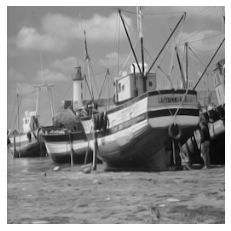

In [17]:
plt.imshow(denoised_image_array, cmap='gray', vmin=0, vmax=255)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()